In [1]:
# The environment for this file is a ~/work/rl
import argparse
import errno
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import torch
import yaml
import numpy as np
import pandas as pd

from utils.environement import GridWorld
from utils.ground_truth import GroundTruth
from utils.helper import submodular_optimization, idxfromloc
from utils.initializer import get_players_initialized
import types
import networkx as nx

In [2]:
# warnings.filterwarnings("ignore")
workspace = '/home/mht/PycharmProjects/SafeMaC'
# parser = argparse.ArgumentParser(description="A foo that bars")
# parser.add_argument("--param", default="GPwall_safe_base")  # params
# parser.add_argument("--env_idx", type=int, default=100)
# parser.add_argument("--generate", type=bool, default=True)
# parser.add_argument("--noise_sigma", type=float, default=0.01)
# parser.add_argument("--iter", type=int, default=1000)
# args = parser.parse_args()

args = {'param': 'GPwall_safe_base',
        'env_idx': 100,
        'generate': False,
        'noise_sigma': 0.01,
        'iter': 1000}
args = types.SimpleNamespace(**args)

In [3]:
args.param

'GPwall_safe_base'

In [3]:
env, agent, algo = args.param.split('_')
params = {}
env = 'env_' + env
agent = 'agent_' + agent
algo = 'algo_' + algo
# 1) Load the config file
for param in [env, agent, algo]:
    with open(workspace + "/params/" + param + ".yaml") as file:
        params.update(yaml.load(file, Loader=yaml.FullLoader))
print(params)

if not args.generate:
    params["env"].update({"generate": False})

params["env"].update({"Fx_noise" : args.noise_sigma})
params["agent"].update({"Fx_noise": args.noise_sigma})

env_load_path = (
    workspace
    + "/experiments/"
    + params["experiment"]["folder"] + '_' + str(args.noise_sigma)
    + "/"
    + env + '_'
    + str(args.env_idx)
    + "/"
)
save_path = env_load_path + "/" + args.param + "/"

if not os.path.exists(save_path):
    try:
        os.makedirs(save_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], env_dir=env_load_path
)

grid_V = env.grid_V
# If optimistic set is intersection of 2 common graph, then they take a joint step (solve greedy algorithm combined)
# If pessimistic set is combined, new pessimistic set is union of sets, and agent can travel in union
init_safe = env.get_safe_init()
print("initialized location", init_safe)

# 3.1) Compute optimal location using true function to be used in regret computation
opt = GroundTruth(env, params)
opt.compute_optimal_location_by_expansion()
opt.compute_normalization_factor()
opt_coverage = opt.opt_val.item()

# while running on cluster in parallel sometimes a location in not created if asked by multiple processes
os.makedirs(save_path, exist_ok=True)

# use df to store data.
data = {
    'current_coverage': [],
    # 'sum_max_sigma'     :[],
    'iter': [],
    'instant_regret': [],
    'regret': []
}
data.update({'idx_agent{}'.format(i): [] for i in range(params["env"]["n_players"])})
data.update({'idx_measure{}'.format(i): [] for i in range(params["env"]["n_players"])})




# Start from some safe initial states
train = {}
train["Cx_X"] = init_safe["loc"]
train["Cx_Y"] = env.get_multi_constraint_observation(train["Cx_X"])
train["Fx_X"] = init_safe["loc"]
train["Fx_Y"] = env.get_multi_density_observation(train["Fx_X"])
players = get_players_initialized(train, params, grid_V)

for it, player in enumerate(players):
    player.update_Fx_gp_with_current_data()
    player.update_graph(init_safe["idx"][it])
    player.save_posterior_normalization_const()  # agent.posterior_normalization_const, max of 2beta*sigma.
    player.initialize_location(init_safe["loc"][it])
    data['idx_agent{}'.format(it)].append(idxfromloc(player.grid_V, player.current_location))
    data['idx_measure{}'.format(it)].append(idxfromloc(player.grid_V, player.current_location))
    # haitong: will not do measurement on the initialization. Use current for in-place.
    # measure_loc = player.get_measurement_pt_max(idxfromloc(player.grid_V, player.current_location))


associate_dict = {}
associate_dict[0] = []
for idx in range(params["env"]["n_players"]):
    associate_dict[0].append(idx)

pessi_associate_dict = {}
pessi_associate_dict[0] = []
for idx in range(params["env"]["n_players"]):
    pessi_associate_dict[0].append(idx)

iter = 0
doubling_target_iter = 0
pt1 = None

regret = 0.
# compute coverage based on the initial location
current_coverage = opt.compute_current_multiple_coverage(players, associate_dict)
data.get('current_coverage').append(current_coverage)
data.get('iter').append(0)
data.get('instant_regret').append(opt_coverage - current_coverage)
regret += opt_coverage - current_coverage
data.get('regret').append(regret)

# max_density_sigma = sum([player.get_max_sigma() for player in players]) # sigma is for objective Fx
# data.get('sum_max_sigma').append(max_density_sigma)
# print(iter, max_density_sigma)

# 4) Solve the submodular problem and get a next point to go xi* in pessimistic safe set
associate_dict, pessi_associate_dict, acq_density, M_dist = submodular_optimization(
    players, init_safe, params
)
'''
haitong: in submodular_optimization, goal is set by agent.planned_dist_center & agent.planned_measured_loc.
            we keep both for compatible with previous visualization code.
'''
acq_coverage = torch.stack(list(M_dist[0].values())).detach().numpy()
for player in players:
    player.planning(acq_coverage)

{'env': {'start': -2, 'step_size': 0.5, 'shape': {'x': 8, 'y': 8}, 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.01, 'Fx_lengthscale': 0.7, 'Fx_noise': 0.01, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': 'walls', 'env_file_name': 'env_data.pkl', 'cov_module': 'Sq_exp'}, 'experiment': {'name': 'exploit', 'generate_regret_plot': True, 'folder': 'GP'}, 'agent': {'Lc': 1.5, 'explore_exploit_strategy': 1, 'Cx_lengthscale': 2, 'Cx_noise': 0.007, 'Fx_lengthscale': 0.8, 'Fx_noise': 0.01, 'Cx_beta': 1.5, 'Fx_beta': 2.0, 'mean_shift_val': 2, 'use_goose': True, 'obs_model': 'disc_center', 'cov_module': 'Sq_exp', 'recommend': 'UCB', 'Two_stage': False, 'sol_domain': 'opti'}, 'common': {'dim': 2, 'constraint': 0.3, 'epsilon': 0.15, 'disk_size': 1}, 'algo': {'n_CI_samples': 1, 'n_iter': 200, 'eps_density_thresh': 0.5, 'goose_steps': 150, 'use_doubling_trick': False}}
8 64 8
{'loc': [tensor([0.0000, 0.5000]), tensor([1.5000, 0.0000]), tensor([0.5000, 0.0000])], 'idx': tensor([37, 60, 44])}
initial

/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


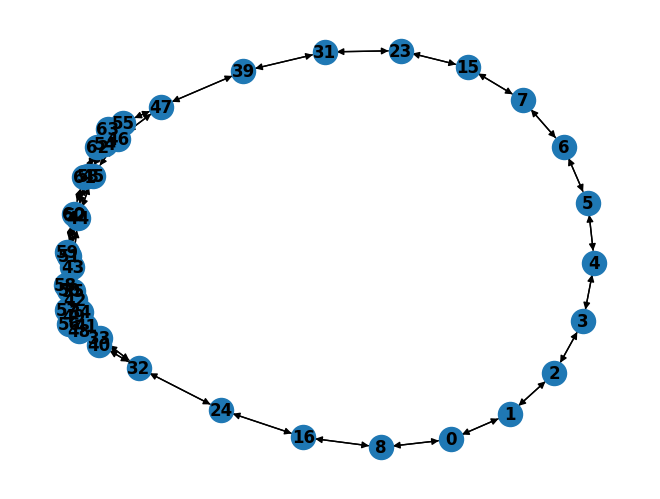

In [8]:
# plt.figure(figsize=(10, 10))
safe_nodes = opt.true_constraint_function > 0.4 + opt.params["common"]["epsilon"]
safe_nodes_idx = torch.arange(0, opt.true_constraint_function.shape[0])[safe_nodes].numpy()
nx.draw_spectral(player.safe_planning_graph.subgraph(safe_nodes_idx), with_labels=True, font_weight='bold')
plt.show()

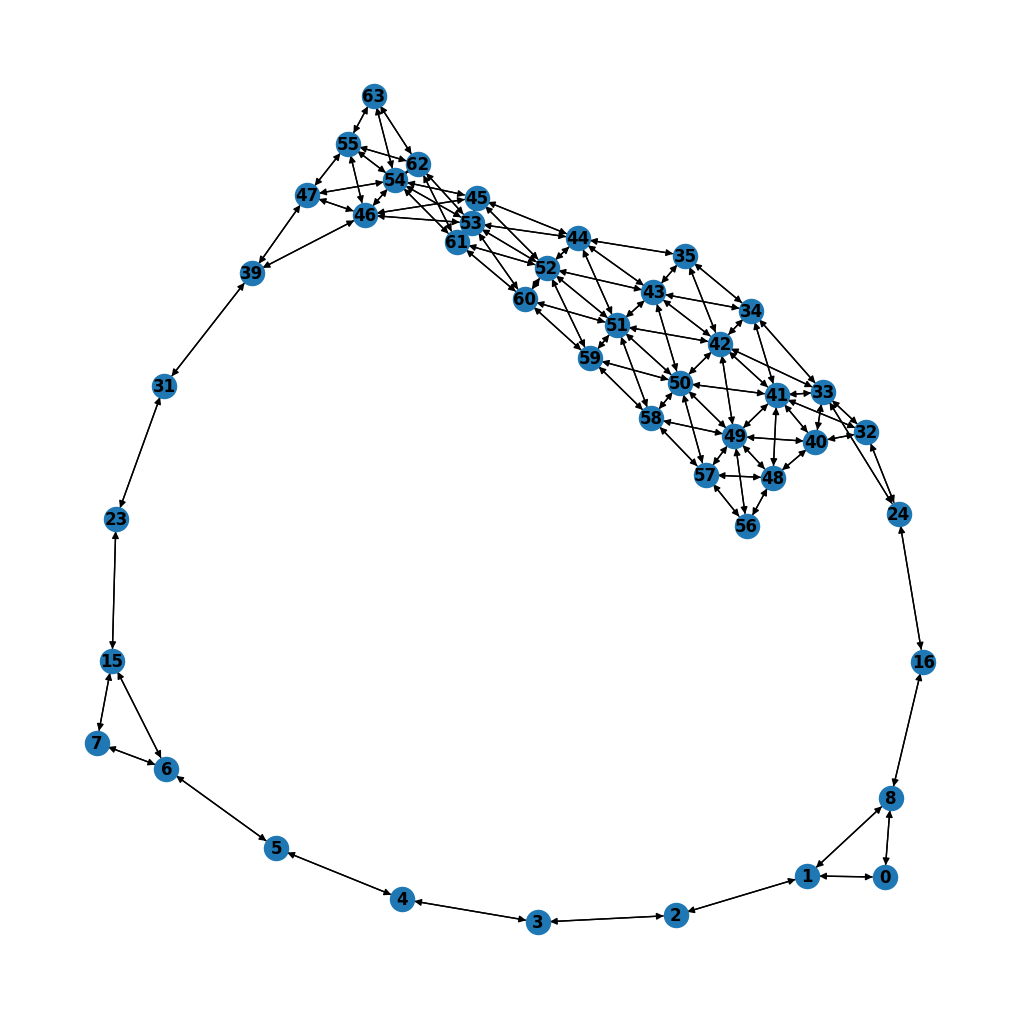

In [13]:
plt.figure(figsize=(10, 10))
player.set_initial_safe_graph(0.4, opt)
nx.draw(player.safe_graph, with_labels=True, font_weight='bold')

In [8]:
opt.true_density

tensor([3.4751, 3.7752, 4.1043, 4.1756, 4.0689, 3.7528, 3.2065, 2.7450, 3.5005,
        3.5778, 4.2214, 4.8064, 4.6721, 4.0356, 3.3890, 2.8884, 3.2842, 2.9095,
        3.5474, 4.3677, 4.2722, 3.6246, 3.2887, 3.2337, 2.8848, 2.2762, 2.8690,
        3.6133, 3.5657, 3.1064, 2.8553, 3.0617, 2.9249, 2.3221, 2.8595, 3.3748,
        3.2675, 2.8101, 2.2391, 2.6742, 3.0108, 2.6541, 2.8886, 2.8362, 2.7120,
        2.6235, 2.0272, 2.5553, 2.6568, 2.9989, 3.1254, 2.4308, 2.0469, 2.4503,
        2.6797, 3.3929, 2.6685, 3.1417, 3.1940, 2.1824, 1.6192, 2.3315, 3.5012,
        4.5142])